# Denoising Autoencoders

In this final lab, we will look at using a denoising autoencoder to remove noise from images. We will use the Fashion MNIST dataset and add noise to the images. We will then train a denoising autoencoder to remove the noise from the images.

Fashion MNIST is a dataset of low resolution images of clothes. It is a popular dataset for image classification and is often used as a drop-in replacement for the original MNIST dataset.

Let's start by loading the dataset and looking at some examples. You'll note that unlike previous labs, we are not even loading the labels! This is because we are going to use the images as both the input and the output of the model.

In [10]:
import tensorflow as tf

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

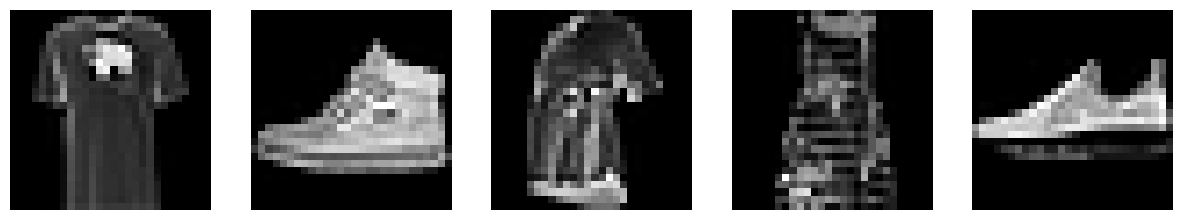

In [11]:
import matplotlib.pyplot as plt
from random import choice

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    ax = axs[i]
    ax.imshow(x_train[choice(range(len(x_train)))], cmap='gray')
    ax.axis('off')

plt.show()

# Adding Noise

Because our model will be trained to remove noise from the images, we need to add noise to the images. We will use a simple method of adding Gaussian noise to the images. We will then clip the values to be between 0 and 1.

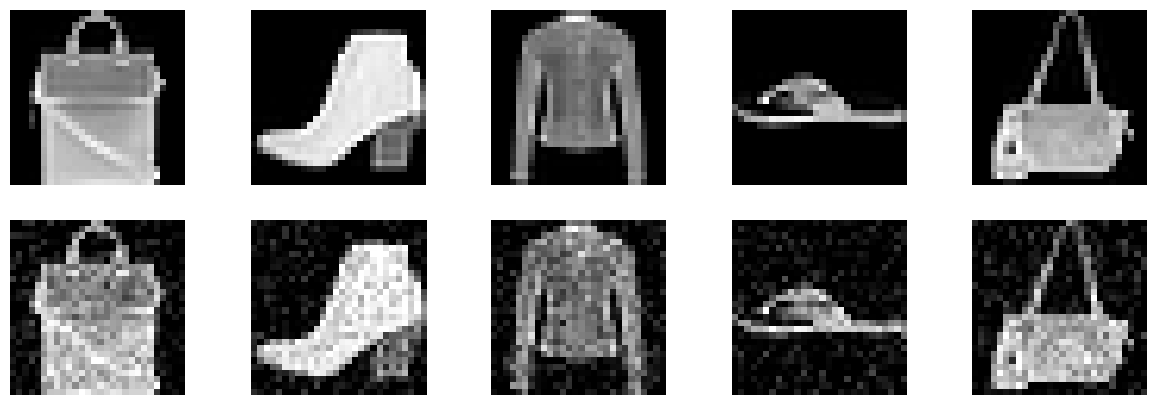

In [12]:
import numpy as np

def add_noise(x, noise_factor=0.1):
    x = x + np.random.normal(loc=0.0, scale=noise_factor, size=x.shape)
    return np.clip(x, 0., 1.)

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

fig, axs = plt.subplots(2, 5, figsize=(15, 5))

for i in range(5):
    ax = axs[0, i]
    idx = choice(range(len(x_train)))
    ax.imshow(x_train[idx], cmap='gray')
    ax.axis('off')

    ax = axs[1, i]
    ax.imshow(x_train_noisy[idx], cmap='gray')
    ax.axis('off')

plt.show()

# Building the Model

Now, let's build a simple autoencoder. This type of model is comprised of two main parts: the encoder and the decoder. The encoder will compress the input image into a lower dimensional representation, and the decoder will attempt to recreate the original image from this lower dimensional representation.

We have completed the encoder for you. It is a simple model that flattens the input image and then passes it through two dense layers. The decoder is your task to complete. It should take the output of the encoder and attempt to recreate the original image.

**Note:** we are used to squashing the output of our model to be between 0 and 1, either with softmax or sigmoid depending on the use case. However, this should not apply to the output of our encoder! The encoder is not outputting a probability, but rather a representation of the input. As such, we should use an activation function like `relu` for the dense layers of the encoder. The decoder, however, should use `sigmoid` to squash the output to be between 0 and 1.

In [13]:
from tensorflow.keras import layers, models
#Had to fix code -- used intermediate dense layer
# Encoder
encoder = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),  # Flatten to 1D (784,)
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu')  # Compressed representation (64,)
])

# Decoder
decoder = models.Sequential([
    layers.Dense(128, activation='relu'),  # Expand back
    layers.Dense(784, activation='sigmoid'),  # Ensure size matches 28x28
    layers.Reshape((28, 28))  # Now reshaping is valid
])

# Autoencoder
autoencoder = models.Sequential([encoder, decoder])

# Compile model
autoencoder.compile(optimizer='adam', loss='mse')

# Print model summary
autoencoder.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (None, 64)                  │         108,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_7 (Sequential)            │ (None, 28, 28)              │         109,456 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,192 (852.31 KB)

 Trainable params: 218,192 (852.31 KB)

 Non-trainable params: 0 (0.00 B)

We will use binary cross-entropy as the loss function, as we are treating the model as a simple logistic regression model. We will use the Adam optimizer to train the model.

In [16]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (None, 64)                  │         108,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_7 (Sequential)            │ (None, 28, 28)              │         109,456 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,192 (852.31 KB)

 Trainable params: 218,192 (852.31 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Special callback to visualize the training progress
#Fixed: since Keras 3 no longer supports TensorFlow's SavedModel format
from tensorflow.keras.callbacks import Callback

def plot_image(i):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    axs[0].imshow(x_test[i], cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    axs[1].imshow(x_test_noisy[i], cmap='gray')
    axs[1].set_title('Noisy')
    axs[1].axis('off')

    axs[2].imshow(autoencoder.predict(x_test_noisy[[i]])[0], cmap='gray')
    axs[2].set_title('De-noised')
    axs[2].axis('off')

    plt.show()

class VisualizeCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        plot_image(3)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(patience=5, monitor='val_loss'),
        ModelCheckpoint('autoencoder.keras', save_best_only=True)  # <-- Use `.keras`
    ]
)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.2675 - val_loss: 0.2707
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.2676 - val_loss: 0.2706
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.2679 - val_loss: 0.2705
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.2675 - val_loss: 0.2706
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.2675 - val_loss: 0.2705
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.2678 - val_loss: 0.2704
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2672 - val_loss: 0.2704
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.2668 - val_loss: 0.2705
Epoch 9/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.2674 - val_loss: 0.2705
Epoch 10/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.2672 - val_loss: 0.2703
Epoch 11/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.2670 - val_loss: 0.2703
Epoch 12/50
422/422 ━━━━━━━━━━━━━━━━━━━

In [22]:
from tensorflow.keras import models

# Load the best saved model
autoencoder = models.load_model('autoencoder.keras')  # <-- Use `.keras`


# Evaluating the Model

Now that we have trained the model, let's see how well it can remove noise from the images. Use the `plot_image` method to visualize the original images, the noisy images, and the denoised images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


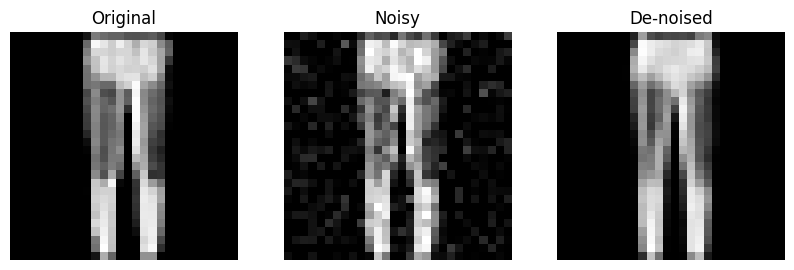

In [23]:
plot_image(3)

# Using Autoencoders for Dimensionality Reduction

During the course, we've looked at standard techniques for dimensionality reduction - PCA and t-SNE. We can also use autoencoders for dimensionality reduction. The output of our encoder is a lower-dimensional representation of the input, which is used by the decoder to recreate that input. As a result, we can use just the encoder to get a low-dimensional representation of our input data.

In the code below, modify your encoder and decoder so that the encoder outputs a 2-dimensional representation of the input. For this task, we won't use the noisy images to train, since our priority now is creating an accurate representation of the original images. This time we will also work with the labels, but only to visualize the data in 2D.

In [24]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [26]:
from tensorflow.keras import layers, models
#Fixed: expanded the 2D representation back to 784 values before reshaping
# Encoder
encoder = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation=None)
])

# Decoder
decoder = models.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(784, activation='sigmoid'),
    layers.Reshape((28, 28))
])

# Autoencoder
autoencoder = models.Sequential([encoder, decoder])

# Compile model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Print model summary
autoencoder.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)           │ (None, 2)                   │         100,738 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_13 (Sequential)           │ (None, 28, 28)              │         101,520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 202,258 (790.07 KB)

 Trainable params: 202,258 (790.07 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#Fixed: added keras extension
autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(patience=5, monitor='val_loss'),
        ModelCheckpoint('autoencoder.keras', save_best_only=True)  # <-- FIXED
    ]
)


Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.4489 - val_loss: 0.3649
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.3543 - val_loss: 0.3484
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.3429 - val_loss: 0.3437
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.3398 - val_loss: 0.3414
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.3374 - val_loss: 0.3399
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.3352 - val_loss: 0.3383
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.3345 - val_loss: 0.3371
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.3331 - val_loss: 0.3361
Epoch 9/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.3322 - val_loss: 0.3350
Epoch 10/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.3311 - val_loss: 0.3351
Epoch 11/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.3300 - val_loss: 0.3332
Epoch 12/50
422/422 ━━━━━━━━━━━━━━━━━━

In [30]:
from tensorflow.keras.models import load_model

autoencoder = load_model('autoencoder.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


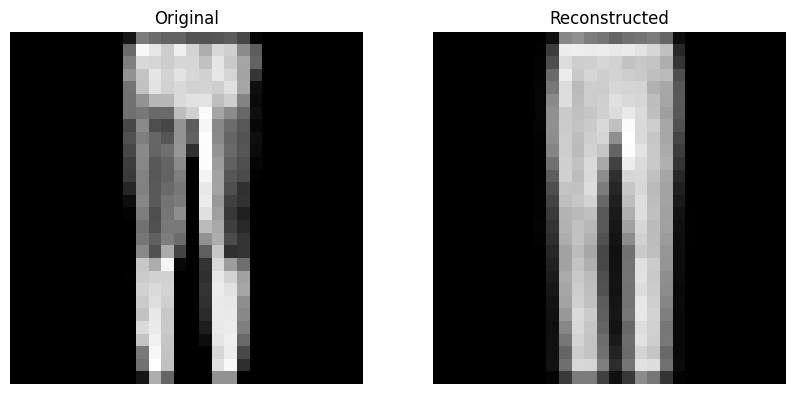

In [31]:
# Visualize reconstruction
def plot_reconstruction(i):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(x_test[i], cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')

    axs[1].imshow(autoencoder.predict(x_test[[i]])[0], cmap='gray')
    axs[1].set_title('Reconstructed')
    axs[1].axis('off')

    plt.show()

plot_reconstruction(3)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


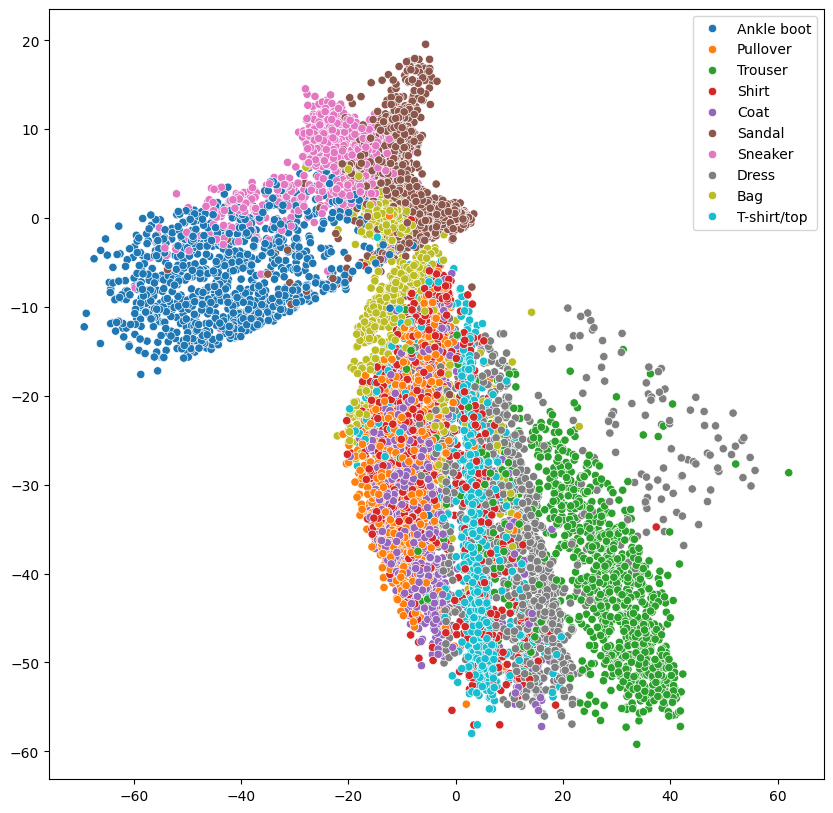

In [32]:
import seaborn as sns

encoded = encoder.predict(x_test)

labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

plt.figure(figsize=(10, 10))
sns.scatterplot(x=encoded[:, 0], y=encoded[:, 1], hue=[labels[i] for i in y_test], palette='tab10')
plt.show()

# Exercises

1. In the first part of the lab, we added Gaussian noise to the images. You can add different types of noise - take a look at some of the options available in numpy [here](https://numpy.org/doc/stable/reference/random/) and try adding different types of noise to the images. How does this affect the performance of the autoencoder?

2. In the second part of the lab, we used the encoder to create a 2-dimensional representation of the input data. We then visualized this representation using a scatter plot. You can also use 3 dimensions instead of 2. How does this affect the reconstruction error? Use the code below to visualize 3D data.

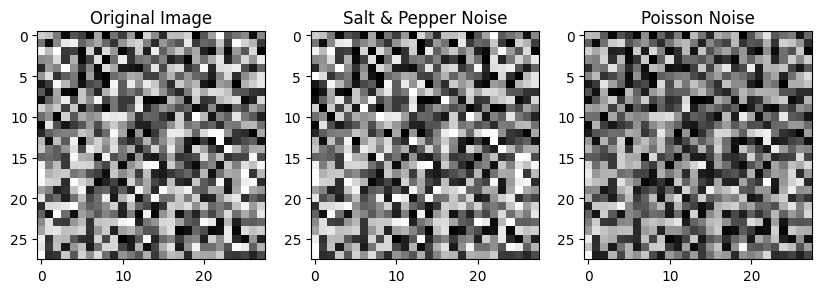

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0834
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0835
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0833
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0834
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0832
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0833
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0835
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0833
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0833
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0834
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


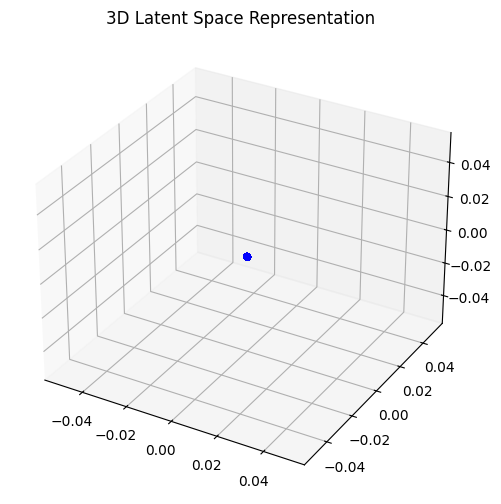

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

# Function to add Salt & Pepper Noise
def add_salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    noisy_image = image.copy()
    total_pixels = image.size
    num_salt = int(total_pixels * salt_prob)
    num_pepper = int(total_pixels * pepper_prob)

    salt_coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]

    noisy_image[salt_coords[0], salt_coords[1]] = 1
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0
    return noisy_image

# Function to add Poisson Noise
def add_poisson_noise(image):
    return np.random.poisson(image * 255) / 255.0

# Generate Sample Noisy Images
original_image = np.random.rand(28, 28)  # Random Image Placeholder
noisy_salt_pepper = add_salt_and_pepper_noise(original_image)
noisy_poisson = add_poisson_noise(original_image)

# Plot images
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
ax[0].imshow(original_image, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(noisy_salt_pepper, cmap='gray')
ax[1].set_title("Salt & Pepper Noise")
ax[2].imshow(noisy_poisson, cmap='gray')
ax[2].set_title("Poisson Noise")
plt.show()

# 3D Latent Space Autoencoder
input_dim = 784  # Assuming 28x28 flattened images
latent_dim = 3  # Changing from 2D to 3D

# Encoder
input_img = Input(shape=(input_dim,))
x = Dense(128, activation='relu')(input_img)
x = Dense(64, activation='relu')(x)
encoded = Dense(latent_dim, activation='relu')(x)

# Decoder
x = Dense(64, activation='relu')(encoded)
x = Dense(128, activation='relu')(x)
decoded = Dense(input_dim, activation='sigmoid')(x)

# Models
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Generate Sample Data and Train
x_train = np.random.rand(1000, 784)  # Placeholder training data
autoencoder.fit(x_train, x_train, epochs=10, batch_size=32, verbose=1)

# Visualize 3D Latent Space
encoded_imgs = encoder.predict(x_train)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], encoded_imgs[:, 2], c='blue', alpha=0.5)
ax.set_title("3D Latent Space Representation")
plt.show()

# Function to plot 3D reconstruction
def plot_3d_reconstruction(num_samples=3):
    fig = plt.figure(figsize=(8, 8))
    for i in range(num_samples):
        ax = fig.add_subplot(1, num_samples, i+1, projection='3d')
        ax.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], encoded_imgs[:, 2], c='blue', alpha=0.5)
        ax.set_title(f"Sample {i+1}")
    plt.show()



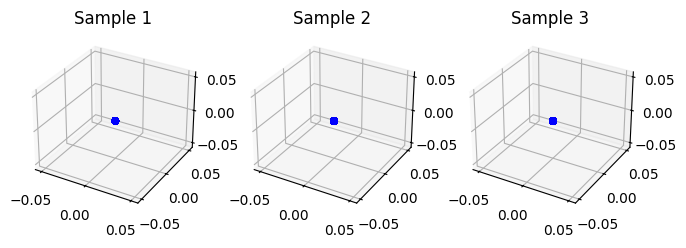

In [36]:
plot_3d_reconstruction(3)